## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [1]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [2]:
## Import Keras objects for Deep Learning

from keras.models  import Sequential, K
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

Using TensorFlow backend.


In [13]:
## Load in the data set (Internet Access needed)
import os
#url = "https://www.kaggle.com/uciml/pima-indians-diabetes-database"  #"http://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
#diabetes_df = pd.read_csv(url, names=names)
diabetes_df = pd.read_csv('diabetes.csv')
diabetes_df.columns = names

In [14]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
404,5,168,64,0,0,32.9,0.135,41,1
458,10,148,84,48,237,37.6,1.001,51,1
394,4,158,78,0,0,32.9,0.803,31,1
671,1,99,58,10,0,25.4,0.551,21,0
50,1,103,80,11,82,19.4,0.491,22,0


In [15]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [16]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [17]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [18]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [20]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.760
roc-auc is 0.820


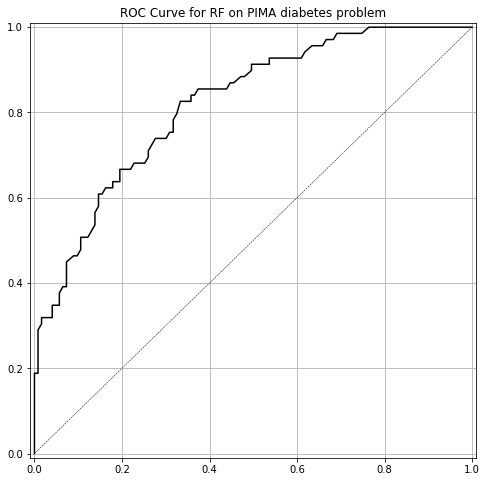

In [21]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [22]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications


normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [28]:
# Define the Model 
# Input size is 8-dimensional    # maybe because it is 9 column.... 8 x and 1 y
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential([
    Dense(12, input_shape=(8,), activation="sigmoid"),
    Dense(1, activation="sigmoid")
])

In [29]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
Why do we have 121 parameters?  Does that make sense?


Let's fit our model for 200 epochs.

In [32]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Train on 576 samples, validate on 192 samples
Epoch 1/200
576/576 [==============================] - 0s 390us/step - loss: 0.5538 - acc: 0.7014 - val_loss: 0.5650 - val_acc: 0.7083
Epoch 2/200
576/576 [==============================] - 0s 50us/step - loss: 0.5534 - acc: 0.7031 - val_loss: 0.5646 - val_acc: 0.7083
Epoch 3/200
576/576 [==============================] - 0s 50us/step - loss: 0.5530 - acc: 0.7031 - val_loss: 0.5642 - val_acc: 0.7083
Epoch 4/200
576/576 [==============================] - 0s 51us/step - loss: 0.5526 - acc: 0.7031 - val_loss: 0.5639 - val_acc: 0.7135
Epoch 5/200
576/576 [==============================] - 0s 50us/step - loss: 0.5522 - acc: 0.7049 - val_loss: 0.5635 - val_acc: 0.7135
Epoch 6/200
576/576 [==============================] - 0s 50us/step - loss: 0.5518 - acc: 0.7049 - val_loss: 0.5631 - val_acc: 0.7135
Epoch 7/200
576/576 [==============================] - 0s 50us/step - loss: 0.5514 - acc: 0.7049 - val_loss: 0.5627 - val_acc: 0.7188
Epoch 8/200
576

576/576 [==============================] - 0s 49us/step - loss: 0.5330 - acc: 0.7396 - val_loss: 0.5452 - val_acc: 0.7604
Epoch 62/200
576/576 [==============================] - 0s 47us/step - loss: 0.5327 - acc: 0.7396 - val_loss: 0.5449 - val_acc: 0.7656
Epoch 63/200
576/576 [==============================] - 0s 42us/step - loss: 0.5325 - acc: 0.7396 - val_loss: 0.5446 - val_acc: 0.7656
Epoch 64/200
576/576 [==============================] - 0s 41us/step - loss: 0.5321 - acc: 0.7396 - val_loss: 0.5443 - val_acc: 0.7656
Epoch 65/200
576/576 [==============================] - 0s 39us/step - loss: 0.5319 - acc: 0.7431 - val_loss: 0.5441 - val_acc: 0.7656
Epoch 66/200
576/576 [==============================] - 0s 41us/step - loss: 0.5316 - acc: 0.7413 - val_loss: 0.5438 - val_acc: 0.7656
Epoch 67/200
576/576 [==============================] - 0s 41us/step - loss: 0.5313 - acc: 0.7431 - val_loss: 0.5435 - val_acc: 0.7656
Epoch 68/200
576/576 [==============================] - 0s 43us/step

576/576 [==============================] - 0s 43us/step - loss: 0.5172 - acc: 0.7587 - val_loss: 0.5306 - val_acc: 0.7708
Epoch 122/200
576/576 [==============================] - 0s 57us/step - loss: 0.5170 - acc: 0.7587 - val_loss: 0.5304 - val_acc: 0.7708
Epoch 123/200
576/576 [==============================] - 0s 48us/step - loss: 0.5168 - acc: 0.7587 - val_loss: 0.5301 - val_acc: 0.7708
Epoch 124/200
576/576 [==============================] - 0s 53us/step - loss: 0.5165 - acc: 0.7587 - val_loss: 0.5299 - val_acc: 0.7708
Epoch 125/200
576/576 [==============================] - 0s 52us/step - loss: 0.5163 - acc: 0.7587 - val_loss: 0.5297 - val_acc: 0.7708
Epoch 126/200
576/576 [==============================] - 0s 48us/step - loss: 0.5161 - acc: 0.7587 - val_loss: 0.5295 - val_acc: 0.7708
Epoch 127/200
576/576 [==============================] - 0s 54us/step - loss: 0.5159 - acc: 0.7587 - val_loss: 0.5293 - val_acc: 0.7708
Epoch 128/200
576/576 [==============================] - 0s 57

576/576 [==============================] - 0s 48us/step - loss: 0.5052 - acc: 0.7691 - val_loss: 0.5199 - val_acc: 0.7708
Epoch 182/200
576/576 [==============================] - 0s 50us/step - loss: 0.5050 - acc: 0.7674 - val_loss: 0.5197 - val_acc: 0.7708
Epoch 183/200
576/576 [==============================] - 0s 48us/step - loss: 0.5048 - acc: 0.7691 - val_loss: 0.5196 - val_acc: 0.7708
Epoch 184/200
576/576 [==============================] - 0s 48us/step - loss: 0.5046 - acc: 0.7674 - val_loss: 0.5194 - val_acc: 0.7708
Epoch 185/200
576/576 [==============================] - 0s 48us/step - loss: 0.5045 - acc: 0.7674 - val_loss: 0.5193 - val_acc: 0.7708
Epoch 186/200
576/576 [==============================] - 0s 46us/step - loss: 0.5043 - acc: 0.7674 - val_loss: 0.5191 - val_acc: 0.7708
Epoch 187/200
576/576 [==============================] - 0s 52us/step - loss: 0.5041 - acc: 0.7674 - val_loss: 0.5190 - val_acc: 0.7708
Epoch 188/200
576/576 [==============================] - 0s 53

In [33]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

In [34]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0]], dtype=int32)

In [35]:
y_pred_prob_nn_1[:10]    # it is the rounded value of y_pred_class

array([[0.40169004],
       [0.5966177 ],
       [0.3196603 ],
       [0.2860103 ],
       [0.218537  ],
       [0.5058101 ],
       [0.14239025],
       [0.3084938 ],
       [0.7081858 ],
       [0.27125615]], dtype=float32)

accuracy is 0.771
roc-auc is 0.817


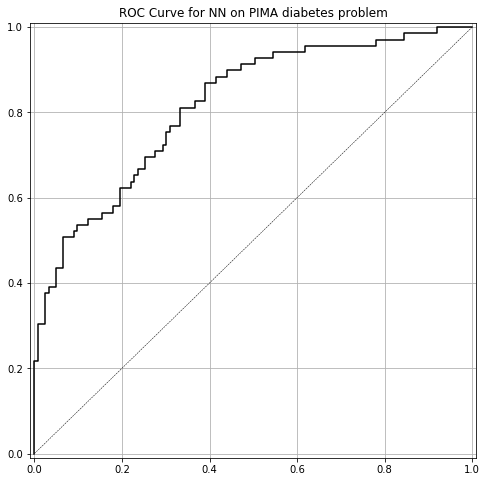

In [36]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [37]:
run_hist_1.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

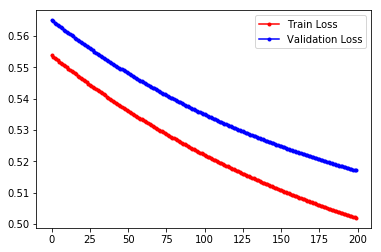

In [38]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [39]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Train on 576 samples, validate on 192 samples
Epoch 1/1000
576/576 [==============================] - 0s 51us/step - loss: 0.5018 - acc: 0.7656 - val_loss: 0.5170 - val_acc: 0.7708
Epoch 2/1000
576/576 [==============================] - 0s 57us/step - loss: 0.5016 - acc: 0.7656 - val_loss: 0.5168 - val_acc: 0.7708
Epoch 3/1000
576/576 [==============================] - 0s 53us/step - loss: 0.5015 - acc: 0.7639 - val_loss: 0.5167 - val_acc: 0.7708
Epoch 4/1000
576/576 [==============================] - 0s 52us/step - loss: 0.5013 - acc: 0.7674 - val_loss: 0.5166 - val_acc: 0.7708
Epoch 5/1000
576/576 [==============================] - 0s 54us/step - loss: 0.5012 - acc: 0.7656 - val_loss: 0.5164 - val_acc: 0.7708
Epoch 6/1000
576/576 [==============================] - 0s 52us/step - loss: 0.5010 - acc: 0.7656 - val_loss: 0.5163 - val_acc: 0.7708
Epoch 7/1000
576/576 [==============================] - 0s 49us/step - loss: 0.5009 - acc: 0.7656 - val_loss: 0.5162 - val_acc: 0.7708
Epoch 8/1

Epoch 61/1000
576/576 [==============================] - 0s 58us/step - loss: 0.4933 - acc: 0.7622 - val_loss: 0.5099 - val_acc: 0.7708
Epoch 62/1000
576/576 [==============================] - 0s 48us/step - loss: 0.4932 - acc: 0.7604 - val_loss: 0.5098 - val_acc: 0.7708
Epoch 63/1000
576/576 [==============================] - 0s 44us/step - loss: 0.4930 - acc: 0.7622 - val_loss: 0.5097 - val_acc: 0.7708
Epoch 64/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4929 - acc: 0.7604 - val_loss: 0.5096 - val_acc: 0.7708
Epoch 65/1000
576/576 [==============================] - 0s 46us/step - loss: 0.4928 - acc: 0.7622 - val_loss: 0.5095 - val_acc: 0.7708
Epoch 66/1000
576/576 [==============================] - 0s 44us/step - loss: 0.4927 - acc: 0.7639 - val_loss: 0.5094 - val_acc: 0.7708
Epoch 67/1000
576/576 [==============================] - 0s 49us/step - loss: 0.4925 - acc: 0.7656 - val_loss: 0.5093 - val_acc: 0.7708
Epoch 68/1000
576/576 [=========================

576/576 [==============================] - 0s 43us/step - loss: 0.4867 - acc: 0.7691 - val_loss: 0.5046 - val_acc: 0.7604
Epoch 122/1000
576/576 [==============================] - 0s 54us/step - loss: 0.4866 - acc: 0.7656 - val_loss: 0.5045 - val_acc: 0.7604
Epoch 123/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4865 - acc: 0.7674 - val_loss: 0.5045 - val_acc: 0.7604
Epoch 124/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4864 - acc: 0.7674 - val_loss: 0.5044 - val_acc: 0.7604
Epoch 125/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4863 - acc: 0.7674 - val_loss: 0.5043 - val_acc: 0.7604
Epoch 126/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4862 - acc: 0.7674 - val_loss: 0.5042 - val_acc: 0.7604
Epoch 127/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4861 - acc: 0.7674 - val_loss: 0.5042 - val_acc: 0.7604
Epoch 128/1000
576/576 [==============================] 

Epoch 181/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4814 - acc: 0.7674 - val_loss: 0.5006 - val_acc: 0.7604
Epoch 182/1000
576/576 [==============================] - 0s 57us/step - loss: 0.4814 - acc: 0.7674 - val_loss: 0.5006 - val_acc: 0.7604
Epoch 183/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4813 - acc: 0.7674 - val_loss: 0.5005 - val_acc: 0.7604
Epoch 184/1000
576/576 [==============================] - 0s 47us/step - loss: 0.4812 - acc: 0.7674 - val_loss: 0.5005 - val_acc: 0.7604
Epoch 185/1000
576/576 [==============================] - 0s 44us/step - loss: 0.4811 - acc: 0.7674 - val_loss: 0.5004 - val_acc: 0.7604
Epoch 186/1000
576/576 [==============================] - 0s 45us/step - loss: 0.4811 - acc: 0.7674 - val_loss: 0.5004 - val_acc: 0.7604
Epoch 187/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4810 - acc: 0.7674 - val_loss: 0.5003 - val_acc: 0.7604
Epoch 188/1000
576/576 [=================

576/576 [==============================] - 0s 43us/step - loss: 0.4774 - acc: 0.7708 - val_loss: 0.4977 - val_acc: 0.7552
Epoch 241/1000
576/576 [==============================] - 0s 46us/step - loss: 0.4773 - acc: 0.7726 - val_loss: 0.4976 - val_acc: 0.7552
Epoch 242/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4772 - acc: 0.7726 - val_loss: 0.4976 - val_acc: 0.7552
Epoch 243/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4772 - acc: 0.7726 - val_loss: 0.4975 - val_acc: 0.7552
Epoch 244/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4771 - acc: 0.7708 - val_loss: 0.4975 - val_acc: 0.7552
Epoch 245/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4771 - acc: 0.7726 - val_loss: 0.4975 - val_acc: 0.7552
Epoch 246/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4770 - acc: 0.7708 - val_loss: 0.4974 - val_acc: 0.7552
Epoch 247/1000
576/576 [==============================] 

Epoch 300/1000
576/576 [==============================] - 0s 47us/step - loss: 0.4740 - acc: 0.7708 - val_loss: 0.4953 - val_acc: 0.7552
Epoch 301/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4740 - acc: 0.7708 - val_loss: 0.4953 - val_acc: 0.7552
Epoch 302/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4739 - acc: 0.7708 - val_loss: 0.4953 - val_acc: 0.7552
Epoch 303/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4739 - acc: 0.7708 - val_loss: 0.4952 - val_acc: 0.7552
Epoch 304/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4738 - acc: 0.7708 - val_loss: 0.4952 - val_acc: 0.7552
Epoch 305/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4738 - acc: 0.7708 - val_loss: 0.4952 - val_acc: 0.7552
Epoch 306/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4737 - acc: 0.7708 - val_loss: 0.4951 - val_acc: 0.7552
Epoch 307/1000
576/576 [=================

Epoch 360/1000
576/576 [==============================] - 0s 45us/step - loss: 0.4713 - acc: 0.7726 - val_loss: 0.4935 - val_acc: 0.7552
Epoch 361/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4713 - acc: 0.7726 - val_loss: 0.4935 - val_acc: 0.7552
Epoch 362/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4712 - acc: 0.7726 - val_loss: 0.4935 - val_acc: 0.7552
Epoch 363/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4712 - acc: 0.7726 - val_loss: 0.4935 - val_acc: 0.7552
Epoch 364/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4712 - acc: 0.7726 - val_loss: 0.4934 - val_acc: 0.7552
Epoch 365/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4711 - acc: 0.7726 - val_loss: 0.4934 - val_acc: 0.7552
Epoch 366/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4711 - acc: 0.7726 - val_loss: 0.4934 - val_acc: 0.7552
Epoch 367/1000
576/576 [=================

Epoch 420/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4691 - acc: 0.7778 - val_loss: 0.4921 - val_acc: 0.7552
Epoch 421/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4691 - acc: 0.7778 - val_loss: 0.4921 - val_acc: 0.7552
Epoch 422/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4691 - acc: 0.7778 - val_loss: 0.4921 - val_acc: 0.7552
Epoch 423/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4690 - acc: 0.7778 - val_loss: 0.4921 - val_acc: 0.7552
Epoch 424/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4690 - acc: 0.7778 - val_loss: 0.4921 - val_acc: 0.7552
Epoch 425/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4689 - acc: 0.7778 - val_loss: 0.4920 - val_acc: 0.7552
Epoch 426/1000
576/576 [==============================] - 0s 44us/step - loss: 0.4689 - acc: 0.7778 - val_loss: 0.4920 - val_acc: 0.7552
Epoch 427/1000
576/576 [=================

Epoch 480/1000
576/576 [==============================] - 0s 46us/step - loss: 0.4673 - acc: 0.7812 - val_loss: 0.4910 - val_acc: 0.7604
Epoch 481/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4673 - acc: 0.7812 - val_loss: 0.4910 - val_acc: 0.7604
Epoch 482/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4673 - acc: 0.7812 - val_loss: 0.4910 - val_acc: 0.7604
Epoch 483/1000
576/576 [==============================] - 0s 39us/step - loss: 0.4672 - acc: 0.7812 - val_loss: 0.4910 - val_acc: 0.7604
Epoch 484/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4672 - acc: 0.7812 - val_loss: 0.4910 - val_acc: 0.7604
Epoch 485/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4672 - acc: 0.7812 - val_loss: 0.4909 - val_acc: 0.7604
Epoch 486/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4672 - acc: 0.7812 - val_loss: 0.4909 - val_acc: 0.7604
Epoch 487/1000
576/576 [=================

Epoch 540/1000
576/576 [==============================] - 0s 45us/step - loss: 0.4658 - acc: 0.7830 - val_loss: 0.4902 - val_acc: 0.7656
Epoch 541/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4658 - acc: 0.7847 - val_loss: 0.4902 - val_acc: 0.7656
Epoch 542/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4658 - acc: 0.7812 - val_loss: 0.4901 - val_acc: 0.7656
Epoch 543/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4658 - acc: 0.7830 - val_loss: 0.4901 - val_acc: 0.7656
Epoch 544/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4657 - acc: 0.7830 - val_loss: 0.4901 - val_acc: 0.7656
Epoch 545/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4657 - acc: 0.7830 - val_loss: 0.4901 - val_acc: 0.7656
Epoch 546/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4657 - acc: 0.7830 - val_loss: 0.4901 - val_acc: 0.7656
Epoch 547/1000
576/576 [=================

576/576 [==============================] - 0s 45us/step - loss: 0.4646 - acc: 0.7847 - val_loss: 0.4895 - val_acc: 0.7656
Epoch 600/1000
576/576 [==============================] - 0s 45us/step - loss: 0.4646 - acc: 0.7847 - val_loss: 0.4895 - val_acc: 0.7656
Epoch 601/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4646 - acc: 0.7847 - val_loss: 0.4895 - val_acc: 0.7656
Epoch 602/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4646 - acc: 0.7830 - val_loss: 0.4895 - val_acc: 0.7656
Epoch 603/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4646 - acc: 0.7847 - val_loss: 0.4895 - val_acc: 0.7656
Epoch 604/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4645 - acc: 0.7847 - val_loss: 0.4895 - val_acc: 0.7656
Epoch 605/1000
576/576 [==============================] - 0s 44us/step - loss: 0.4645 - acc: 0.7847 - val_loss: 0.4894 - val_acc: 0.7656
Epoch 606/1000
576/576 [==============================] 

Epoch 659/1000
576/576 [==============================] - 0s 44us/step - loss: 0.4636 - acc: 0.7812 - val_loss: 0.4890 - val_acc: 0.7604
Epoch 660/1000
576/576 [==============================] - 0s 49us/step - loss: 0.4636 - acc: 0.7812 - val_loss: 0.4890 - val_acc: 0.7604
Epoch 661/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4636 - acc: 0.7830 - val_loss: 0.4890 - val_acc: 0.7604
Epoch 662/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4635 - acc: 0.7812 - val_loss: 0.4890 - val_acc: 0.7604
Epoch 663/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4635 - acc: 0.7795 - val_loss: 0.4889 - val_acc: 0.7604
Epoch 664/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4635 - acc: 0.7795 - val_loss: 0.4889 - val_acc: 0.7604
Epoch 665/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4635 - acc: 0.7795 - val_loss: 0.4889 - val_acc: 0.7604
Epoch 666/1000
576/576 [=================

576/576 [==============================] - 0s 43us/step - loss: 0.4627 - acc: 0.7795 - val_loss: 0.4886 - val_acc: 0.7604
Epoch 719/1000
576/576 [==============================] - 0s 47us/step - loss: 0.4627 - acc: 0.7795 - val_loss: 0.4886 - val_acc: 0.7604
Epoch 720/1000
576/576 [==============================] - 0s 47us/step - loss: 0.4627 - acc: 0.7795 - val_loss: 0.4886 - val_acc: 0.7604
Epoch 721/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4627 - acc: 0.7795 - val_loss: 0.4886 - val_acc: 0.7604
Epoch 722/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4627 - acc: 0.7795 - val_loss: 0.4885 - val_acc: 0.7604
Epoch 723/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4627 - acc: 0.7795 - val_loss: 0.4885 - val_acc: 0.7604
Epoch 724/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4627 - acc: 0.7795 - val_loss: 0.4885 - val_acc: 0.7604
Epoch 725/1000
576/576 [==============================] 

Epoch 778/1000
576/576 [==============================] - 0s 48us/step - loss: 0.4620 - acc: 0.7812 - val_loss: 0.4883 - val_acc: 0.7604
Epoch 779/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4620 - acc: 0.7812 - val_loss: 0.4882 - val_acc: 0.7604
Epoch 780/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4620 - acc: 0.7812 - val_loss: 0.4882 - val_acc: 0.7604
Epoch 781/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4620 - acc: 0.7812 - val_loss: 0.4882 - val_acc: 0.7604
Epoch 782/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4620 - acc: 0.7812 - val_loss: 0.4882 - val_acc: 0.7604
Epoch 783/1000
576/576 [==============================] - 0s 44us/step - loss: 0.4619 - acc: 0.7812 - val_loss: 0.4882 - val_acc: 0.7604
Epoch 784/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4619 - acc: 0.7795 - val_loss: 0.4882 - val_acc: 0.7604
Epoch 785/1000
576/576 [=================

Epoch 838/1000
576/576 [==============================] - 0s 45us/step - loss: 0.4614 - acc: 0.7795 - val_loss: 0.4880 - val_acc: 0.7604
Epoch 839/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4613 - acc: 0.7795 - val_loss: 0.4880 - val_acc: 0.7604
Epoch 840/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4613 - acc: 0.7795 - val_loss: 0.4880 - val_acc: 0.7604
Epoch 841/1000
576/576 [==============================] - 0s 44us/step - loss: 0.4613 - acc: 0.7795 - val_loss: 0.4880 - val_acc: 0.7604
Epoch 842/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4613 - acc: 0.7795 - val_loss: 0.4880 - val_acc: 0.7604
Epoch 843/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4613 - acc: 0.7795 - val_loss: 0.4880 - val_acc: 0.7604
Epoch 844/1000
576/576 [==============================] - 0s 45us/step - loss: 0.4613 - acc: 0.7795 - val_loss: 0.4880 - val_acc: 0.7604
Epoch 845/1000
576/576 [=================

Epoch 898/1000
576/576 [==============================] - 0s 45us/step - loss: 0.4608 - acc: 0.7795 - val_loss: 0.4878 - val_acc: 0.7604
Epoch 899/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4608 - acc: 0.7795 - val_loss: 0.4878 - val_acc: 0.7604
Epoch 900/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4608 - acc: 0.7795 - val_loss: 0.4878 - val_acc: 0.7604
Epoch 901/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4608 - acc: 0.7795 - val_loss: 0.4878 - val_acc: 0.7604
Epoch 902/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4608 - acc: 0.7795 - val_loss: 0.4878 - val_acc: 0.7604
Epoch 903/1000
576/576 [==============================] - 0s 46us/step - loss: 0.4608 - acc: 0.7795 - val_loss: 0.4878 - val_acc: 0.7604
Epoch 904/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4608 - acc: 0.7795 - val_loss: 0.4878 - val_acc: 0.7604
Epoch 905/1000
576/576 [=================

Epoch 958/1000
576/576 [==============================] - 0s 46us/step - loss: 0.4603 - acc: 0.7812 - val_loss: 0.4877 - val_acc: 0.7552
Epoch 959/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4603 - acc: 0.7830 - val_loss: 0.4877 - val_acc: 0.7552
Epoch 960/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4603 - acc: 0.7812 - val_loss: 0.4877 - val_acc: 0.7552
Epoch 961/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4603 - acc: 0.7812 - val_loss: 0.4877 - val_acc: 0.7552
Epoch 962/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4603 - acc: 0.7812 - val_loss: 0.4877 - val_acc: 0.7552
Epoch 963/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4603 - acc: 0.7812 - val_loss: 0.4877 - val_acc: 0.7552
Epoch 964/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4603 - acc: 0.7812 - val_loss: 0.4877 - val_acc: 0.7552
Epoch 965/1000
576/576 [=================

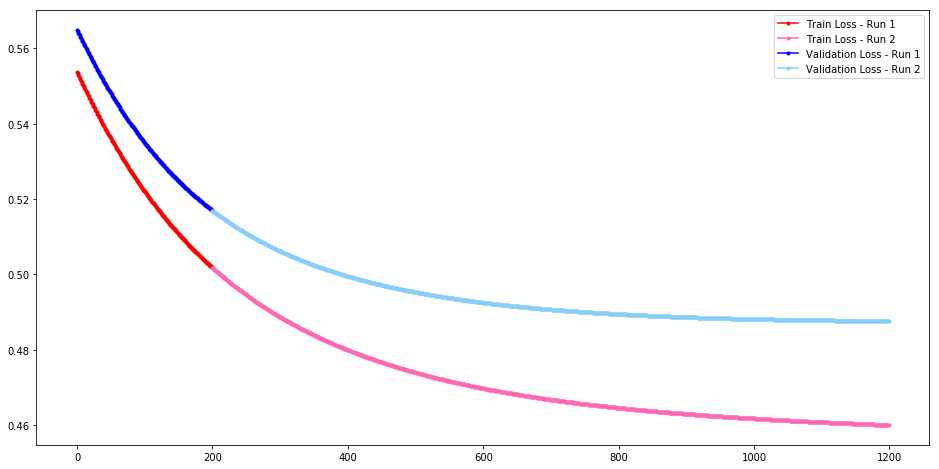

In [40]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

## Exercise
Now it's your turn.  Do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures

In [43]:
# Type your code here to with layer 1,2 having activation relu and layer 3 with activation sigmoid
model_2 = Sequential([
    Dense(6, input_shape=(8,), activation="relu"),
    Dense(6, activation="relu"),
    Dense(1, activation="sigmoid")
    
])
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 6)                 54        
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 7         
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_2.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])   # we could also use different optimizer like adap instead of SGD
run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Train on 576 samples, validate on 192 samples
Epoch 1/1500
576/576 [==============================] - 0s 629us/step - loss: 0.6716 - acc: 0.6285 - val_loss: 0.6803 - val_acc: 0.6302
Epoch 2/1500
576/576 [==============================] - 0s 50us/step - loss: 0.6703 - acc: 0.6285 - val_loss: 0.6792 - val_acc: 0.6302
Epoch 3/1500
576/576 [==============================] - 0s 49us/step - loss: 0.6690 - acc: 0.6319 - val_loss: 0.6781 - val_acc: 0.6302
Epoch 4/1500
576/576 [==============================] - 0s 51us/step - loss: 0.6677 - acc: 0.6267 - val_loss: 0.6770 - val_acc: 0.6198
Epoch 5/1500
576/576 [==============================] - 0s 51us/step - loss: 0.6664 - acc: 0.6267 - val_loss: 0.6759 - val_acc: 0.6146
Epoch 6/1500
576/576 [==============================] - 0s 52us/step - loss: 0.6652 - acc: 0.6302 - val_loss: 0.6748 - val_acc: 0.6302
Epoch 7/1500
576/576 [==============================] - 0s 51us/step - loss: 0.6639 - acc: 0.6372 - val_loss: 0.6738 - val_acc: 0.6354
Epoch 8/

Epoch 61/1500
576/576 [==============================] - 0s 50us/step - loss: 0.6092 - acc: 0.6562 - val_loss: 0.6278 - val_acc: 0.6406
Epoch 62/1500
576/576 [==============================] - 0s 44us/step - loss: 0.6082 - acc: 0.6562 - val_loss: 0.6270 - val_acc: 0.6406
Epoch 63/1500
576/576 [==============================] - 0s 44us/step - loss: 0.6073 - acc: 0.6545 - val_loss: 0.6263 - val_acc: 0.6406
Epoch 64/1500
576/576 [==============================] - 0s 43us/step - loss: 0.6064 - acc: 0.6545 - val_loss: 0.6255 - val_acc: 0.6406
Epoch 65/1500
576/576 [==============================] - 0s 44us/step - loss: 0.6054 - acc: 0.6545 - val_loss: 0.6247 - val_acc: 0.6406
Epoch 66/1500
576/576 [==============================] - 0s 43us/step - loss: 0.6045 - acc: 0.6545 - val_loss: 0.6239 - val_acc: 0.6406
Epoch 67/1500
576/576 [==============================] - 0s 44us/step - loss: 0.6035 - acc: 0.6545 - val_loss: 0.6231 - val_acc: 0.6406
Epoch 68/1500
576/576 [=========================

576/576 [==============================] - 0s 50us/step - loss: 0.5490 - acc: 0.6684 - val_loss: 0.5813 - val_acc: 0.6510
Epoch 122/1500
576/576 [==============================] - 0s 56us/step - loss: 0.5481 - acc: 0.6667 - val_loss: 0.5806 - val_acc: 0.6510
Epoch 123/1500
576/576 [==============================] - 0s 47us/step - loss: 0.5471 - acc: 0.6667 - val_loss: 0.5799 - val_acc: 0.6562
Epoch 124/1500
576/576 [==============================] - 0s 53us/step - loss: 0.5462 - acc: 0.6667 - val_loss: 0.5792 - val_acc: 0.6615
Epoch 125/1500
576/576 [==============================] - 0s 51us/step - loss: 0.5452 - acc: 0.6701 - val_loss: 0.5786 - val_acc: 0.6615
Epoch 126/1500
576/576 [==============================] - 0s 52us/step - loss: 0.5443 - acc: 0.6719 - val_loss: 0.5779 - val_acc: 0.6615
Epoch 127/1500
576/576 [==============================] - 0s 54us/step - loss: 0.5434 - acc: 0.6701 - val_loss: 0.5772 - val_acc: 0.6615
Epoch 128/1500
576/576 [==============================] 

Epoch 181/1500
576/576 [==============================] - 0s 46us/step - loss: 0.5025 - acc: 0.7535 - val_loss: 0.5498 - val_acc: 0.7240
Epoch 182/1500
576/576 [==============================] - 0s 42us/step - loss: 0.5018 - acc: 0.7587 - val_loss: 0.5494 - val_acc: 0.7240
Epoch 183/1500
576/576 [==============================] - 0s 43us/step - loss: 0.5012 - acc: 0.7587 - val_loss: 0.5490 - val_acc: 0.7292
Epoch 184/1500
576/576 [==============================] - 0s 41us/step - loss: 0.5006 - acc: 0.7639 - val_loss: 0.5487 - val_acc: 0.7292
Epoch 185/1500
576/576 [==============================] - 0s 41us/step - loss: 0.5000 - acc: 0.7639 - val_loss: 0.5483 - val_acc: 0.7292
Epoch 186/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4994 - acc: 0.7674 - val_loss: 0.5480 - val_acc: 0.7292
Epoch 187/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4989 - acc: 0.7674 - val_loss: 0.5476 - val_acc: 0.7292
Epoch 188/1500
576/576 [=================

Epoch 241/1500
576/576 [==============================] - 0s 45us/step - loss: 0.4760 - acc: 0.7778 - val_loss: 0.5350 - val_acc: 0.7396
Epoch 242/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4757 - acc: 0.7778 - val_loss: 0.5349 - val_acc: 0.7396
Epoch 243/1500
576/576 [==============================] - 0s 44us/step - loss: 0.4754 - acc: 0.7778 - val_loss: 0.5348 - val_acc: 0.7396
Epoch 244/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4751 - acc: 0.7778 - val_loss: 0.5346 - val_acc: 0.7396
Epoch 245/1500
576/576 [==============================] - 0s 44us/step - loss: 0.4749 - acc: 0.7778 - val_loss: 0.5345 - val_acc: 0.7448
Epoch 246/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4746 - acc: 0.7778 - val_loss: 0.5344 - val_acc: 0.7448
Epoch 247/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4743 - acc: 0.7795 - val_loss: 0.5343 - val_acc: 0.7448
Epoch 248/1500
576/576 [=================

Epoch 301/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4626 - acc: 0.7830 - val_loss: 0.5301 - val_acc: 0.7500
Epoch 302/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4624 - acc: 0.7830 - val_loss: 0.5301 - val_acc: 0.7500
Epoch 303/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4623 - acc: 0.7830 - val_loss: 0.5301 - val_acc: 0.7448
Epoch 304/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4621 - acc: 0.7830 - val_loss: 0.5300 - val_acc: 0.7448
Epoch 305/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4620 - acc: 0.7830 - val_loss: 0.5300 - val_acc: 0.7448
Epoch 306/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4618 - acc: 0.7830 - val_loss: 0.5299 - val_acc: 0.7448
Epoch 307/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4617 - acc: 0.7812 - val_loss: 0.5299 - val_acc: 0.7448
Epoch 308/1500
576/576 [=================

Epoch 361/1500
576/576 [==============================] - 0s 51us/step - loss: 0.4555 - acc: 0.7795 - val_loss: 0.5285 - val_acc: 0.7448
Epoch 362/1500
576/576 [==============================] - 0s 49us/step - loss: 0.4554 - acc: 0.7795 - val_loss: 0.5285 - val_acc: 0.7448
Epoch 363/1500
576/576 [==============================] - 0s 46us/step - loss: 0.4553 - acc: 0.7795 - val_loss: 0.5285 - val_acc: 0.7448
Epoch 364/1500
576/576 [==============================] - 0s 45us/step - loss: 0.4552 - acc: 0.7795 - val_loss: 0.5285 - val_acc: 0.7448
Epoch 365/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4551 - acc: 0.7795 - val_loss: 0.5285 - val_acc: 0.7448
Epoch 366/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4551 - acc: 0.7795 - val_loss: 0.5285 - val_acc: 0.7448
Epoch 367/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4549 - acc: 0.7795 - val_loss: 0.5285 - val_acc: 0.7448
Epoch 368/1500
576/576 [=================

Epoch 421/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4509 - acc: 0.7778 - val_loss: 0.5285 - val_acc: 0.7448
Epoch 422/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4509 - acc: 0.7778 - val_loss: 0.5285 - val_acc: 0.7448
Epoch 423/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4508 - acc: 0.7778 - val_loss: 0.5285 - val_acc: 0.7448
Epoch 424/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4507 - acc: 0.7778 - val_loss: 0.5285 - val_acc: 0.7448
Epoch 425/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4506 - acc: 0.7778 - val_loss: 0.5285 - val_acc: 0.7448
Epoch 426/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4505 - acc: 0.7778 - val_loss: 0.5285 - val_acc: 0.7448
Epoch 427/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4505 - acc: 0.7795 - val_loss: 0.5285 - val_acc: 0.7448
Epoch 428/1500
576/576 [=================

Epoch 481/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4470 - acc: 0.7795 - val_loss: 0.5282 - val_acc: 0.7500
Epoch 482/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4469 - acc: 0.7795 - val_loss: 0.5282 - val_acc: 0.7500
Epoch 483/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4468 - acc: 0.7795 - val_loss: 0.5283 - val_acc: 0.7500
Epoch 484/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4468 - acc: 0.7795 - val_loss: 0.5283 - val_acc: 0.7500
Epoch 485/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4467 - acc: 0.7795 - val_loss: 0.5283 - val_acc: 0.7500
Epoch 486/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4466 - acc: 0.7795 - val_loss: 0.5283 - val_acc: 0.7500
Epoch 487/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4466 - acc: 0.7795 - val_loss: 0.5283 - val_acc: 0.7500
Epoch 488/1500
576/576 [=================

Epoch 541/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4432 - acc: 0.7882 - val_loss: 0.5288 - val_acc: 0.7552
Epoch 542/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4432 - acc: 0.7882 - val_loss: 0.5288 - val_acc: 0.7552
Epoch 543/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4431 - acc: 0.7882 - val_loss: 0.5289 - val_acc: 0.7552
Epoch 544/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4431 - acc: 0.7882 - val_loss: 0.5289 - val_acc: 0.7552
Epoch 545/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4430 - acc: 0.7882 - val_loss: 0.5289 - val_acc: 0.7552
Epoch 546/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4430 - acc: 0.7882 - val_loss: 0.5289 - val_acc: 0.7500
Epoch 547/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4429 - acc: 0.7882 - val_loss: 0.5289 - val_acc: 0.7500
Epoch 548/1500
576/576 [=================

Epoch 601/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4400 - acc: 0.7899 - val_loss: 0.5295 - val_acc: 0.7396
Epoch 602/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4400 - acc: 0.7899 - val_loss: 0.5296 - val_acc: 0.7396
Epoch 603/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4399 - acc: 0.7899 - val_loss: 0.5296 - val_acc: 0.7396
Epoch 604/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4399 - acc: 0.7899 - val_loss: 0.5296 - val_acc: 0.7396
Epoch 605/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4399 - acc: 0.7899 - val_loss: 0.5296 - val_acc: 0.7396
Epoch 606/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4398 - acc: 0.7899 - val_loss: 0.5296 - val_acc: 0.7396
Epoch 607/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4397 - acc: 0.7899 - val_loss: 0.5296 - val_acc: 0.7396
Epoch 608/1500
576/576 [=================

Epoch 661/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4367 - acc: 0.7917 - val_loss: 0.5299 - val_acc: 0.7500
Epoch 662/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4367 - acc: 0.7917 - val_loss: 0.5300 - val_acc: 0.7500
Epoch 663/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4366 - acc: 0.7917 - val_loss: 0.5300 - val_acc: 0.7500
Epoch 664/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4366 - acc: 0.7917 - val_loss: 0.5300 - val_acc: 0.7500
Epoch 665/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4365 - acc: 0.7934 - val_loss: 0.5300 - val_acc: 0.7500
Epoch 666/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4364 - acc: 0.7934 - val_loss: 0.5300 - val_acc: 0.7500
Epoch 667/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4364 - acc: 0.7917 - val_loss: 0.5300 - val_acc: 0.7500
Epoch 668/1500
576/576 [=================

Epoch 721/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4341 - acc: 0.7917 - val_loss: 0.5308 - val_acc: 0.7448
Epoch 722/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4340 - acc: 0.7917 - val_loss: 0.5308 - val_acc: 0.7448
Epoch 723/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4340 - acc: 0.7917 - val_loss: 0.5309 - val_acc: 0.7448
Epoch 724/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4339 - acc: 0.7917 - val_loss: 0.5309 - val_acc: 0.7448
Epoch 725/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4339 - acc: 0.7917 - val_loss: 0.5309 - val_acc: 0.7448
Epoch 726/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4339 - acc: 0.7934 - val_loss: 0.5309 - val_acc: 0.7448
Epoch 727/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4338 - acc: 0.7917 - val_loss: 0.5309 - val_acc: 0.7448
Epoch 728/1500
576/576 [=================

Epoch 781/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4320 - acc: 0.7951 - val_loss: 0.5321 - val_acc: 0.7448
Epoch 782/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4320 - acc: 0.7969 - val_loss: 0.5321 - val_acc: 0.7448
Epoch 783/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4320 - acc: 0.7969 - val_loss: 0.5322 - val_acc: 0.7448
Epoch 784/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4320 - acc: 0.7951 - val_loss: 0.5322 - val_acc: 0.7448
Epoch 785/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4319 - acc: 0.7969 - val_loss: 0.5322 - val_acc: 0.7448
Epoch 786/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4319 - acc: 0.7969 - val_loss: 0.5323 - val_acc: 0.7448
Epoch 787/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4319 - acc: 0.7969 - val_loss: 0.5323 - val_acc: 0.7448
Epoch 788/1500
576/576 [=================

Epoch 841/1500
576/576 [==============================] - 0s 49us/step - loss: 0.4304 - acc: 0.7986 - val_loss: 0.5339 - val_acc: 0.7396
Epoch 842/1500
576/576 [==============================] - 0s 44us/step - loss: 0.4304 - acc: 0.7986 - val_loss: 0.5339 - val_acc: 0.7396
Epoch 843/1500
576/576 [==============================] - 0s 49us/step - loss: 0.4304 - acc: 0.7986 - val_loss: 0.5339 - val_acc: 0.7396
Epoch 844/1500
576/576 [==============================] - 0s 47us/step - loss: 0.4303 - acc: 0.7986 - val_loss: 0.5339 - val_acc: 0.7396
Epoch 845/1500
576/576 [==============================] - 0s 49us/step - loss: 0.4303 - acc: 0.7986 - val_loss: 0.5339 - val_acc: 0.7396
Epoch 846/1500
576/576 [==============================] - 0s 44us/step - loss: 0.4303 - acc: 0.7986 - val_loss: 0.5340 - val_acc: 0.7396
Epoch 847/1500
576/576 [==============================] - 0s 49us/step - loss: 0.4303 - acc: 0.7986 - val_loss: 0.5340 - val_acc: 0.7396
Epoch 848/1500
576/576 [=================

576/576 [==============================] - 0s 39us/step - loss: 0.4289 - acc: 0.8021 - val_loss: 0.5351 - val_acc: 0.7396
Epoch 901/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4289 - acc: 0.8003 - val_loss: 0.5351 - val_acc: 0.7396
Epoch 902/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4289 - acc: 0.8003 - val_loss: 0.5351 - val_acc: 0.7396
Epoch 903/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4288 - acc: 0.8003 - val_loss: 0.5351 - val_acc: 0.7396
Epoch 904/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4288 - acc: 0.8003 - val_loss: 0.5351 - val_acc: 0.7396
Epoch 905/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4288 - acc: 0.8003 - val_loss: 0.5352 - val_acc: 0.7396
Epoch 906/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4288 - acc: 0.8003 - val_loss: 0.5352 - val_acc: 0.7396
Epoch 907/1500
576/576 [==============================] 

Epoch 960/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4278 - acc: 0.8021 - val_loss: 0.5362 - val_acc: 0.7396
Epoch 961/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4278 - acc: 0.8003 - val_loss: 0.5362 - val_acc: 0.7396
Epoch 962/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4277 - acc: 0.8021 - val_loss: 0.5362 - val_acc: 0.7396
Epoch 963/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4277 - acc: 0.8003 - val_loss: 0.5362 - val_acc: 0.7396
Epoch 964/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4277 - acc: 0.8021 - val_loss: 0.5362 - val_acc: 0.7396
Epoch 965/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4277 - acc: 0.8021 - val_loss: 0.5363 - val_acc: 0.7396
Epoch 966/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4277 - acc: 0.8021 - val_loss: 0.5363 - val_acc: 0.7396
Epoch 967/1500
576/576 [=================

576/576 [==============================] - 0s 38us/step - loss: 0.4268 - acc: 0.8090 - val_loss: 0.5373 - val_acc: 0.7396
Epoch 1020/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4268 - acc: 0.8090 - val_loss: 0.5373 - val_acc: 0.7396
Epoch 1021/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4268 - acc: 0.8090 - val_loss: 0.5373 - val_acc: 0.7396
Epoch 1022/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4268 - acc: 0.8090 - val_loss: 0.5373 - val_acc: 0.7396
Epoch 1023/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4267 - acc: 0.8073 - val_loss: 0.5373 - val_acc: 0.7396
Epoch 1024/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4268 - acc: 0.8073 - val_loss: 0.5373 - val_acc: 0.7396
Epoch 1025/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4267 - acc: 0.8073 - val_loss: 0.5374 - val_acc: 0.7396
Epoch 1026/1500
576/576 [=========================

576/576 [==============================] - 0s 38us/step - loss: 0.4259 - acc: 0.8090 - val_loss: 0.5386 - val_acc: 0.7396
Epoch 1079/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4258 - acc: 0.8090 - val_loss: 0.5386 - val_acc: 0.7396
Epoch 1080/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4259 - acc: 0.8090 - val_loss: 0.5386 - val_acc: 0.7396
Epoch 1081/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4258 - acc: 0.8090 - val_loss: 0.5387 - val_acc: 0.7396
Epoch 1082/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4259 - acc: 0.8090 - val_loss: 0.5387 - val_acc: 0.7396
Epoch 1083/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4258 - acc: 0.8073 - val_loss: 0.5388 - val_acc: 0.7396
Epoch 1084/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4258 - acc: 0.8073 - val_loss: 0.5388 - val_acc: 0.7396
Epoch 1085/1500
576/576 [=========================

576/576 [==============================] - 0s 38us/step - loss: 0.4251 - acc: 0.8056 - val_loss: 0.5406 - val_acc: 0.7396
Epoch 1138/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4252 - acc: 0.8038 - val_loss: 0.5406 - val_acc: 0.7396
Epoch 1139/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4251 - acc: 0.8056 - val_loss: 0.5406 - val_acc: 0.7396
Epoch 1140/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4251 - acc: 0.8056 - val_loss: 0.5406 - val_acc: 0.7396
Epoch 1141/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4251 - acc: 0.8056 - val_loss: 0.5407 - val_acc: 0.7396
Epoch 1142/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4251 - acc: 0.8056 - val_loss: 0.5407 - val_acc: 0.7396
Epoch 1143/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4251 - acc: 0.8056 - val_loss: 0.5407 - val_acc: 0.7396
Epoch 1144/1500
576/576 [=========================

576/576 [==============================] - 0s 38us/step - loss: 0.4245 - acc: 0.8038 - val_loss: 0.5420 - val_acc: 0.7396
Epoch 1197/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4245 - acc: 0.8038 - val_loss: 0.5420 - val_acc: 0.7396
Epoch 1198/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4244 - acc: 0.8038 - val_loss: 0.5420 - val_acc: 0.7396
Epoch 1199/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4244 - acc: 0.8038 - val_loss: 0.5421 - val_acc: 0.7396
Epoch 1200/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4244 - acc: 0.8038 - val_loss: 0.5421 - val_acc: 0.7396
Epoch 1201/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4244 - acc: 0.8056 - val_loss: 0.5421 - val_acc: 0.7396
Epoch 1202/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4244 - acc: 0.8056 - val_loss: 0.5421 - val_acc: 0.7396
Epoch 1203/1500
576/576 [=========================

576/576 [==============================] - 0s 39us/step - loss: 0.4239 - acc: 0.8056 - val_loss: 0.5431 - val_acc: 0.7396
Epoch 1256/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4238 - acc: 0.8056 - val_loss: 0.5431 - val_acc: 0.7396
Epoch 1257/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4238 - acc: 0.8056 - val_loss: 0.5431 - val_acc: 0.7396
Epoch 1258/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4238 - acc: 0.8056 - val_loss: 0.5431 - val_acc: 0.7396
Epoch 1259/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4238 - acc: 0.8056 - val_loss: 0.5431 - val_acc: 0.7396
Epoch 1260/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4238 - acc: 0.8056 - val_loss: 0.5431 - val_acc: 0.7396
Epoch 1261/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4238 - acc: 0.8056 - val_loss: 0.5432 - val_acc: 0.7396
Epoch 1262/1500
576/576 [=========================

576/576 [==============================] - 0s 39us/step - loss: 0.4232 - acc: 0.8056 - val_loss: 0.5441 - val_acc: 0.7396
Epoch 1315/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4231 - acc: 0.8056 - val_loss: 0.5441 - val_acc: 0.7396
Epoch 1316/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4232 - acc: 0.8073 - val_loss: 0.5442 - val_acc: 0.7396
Epoch 1317/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4231 - acc: 0.8073 - val_loss: 0.5442 - val_acc: 0.7396
Epoch 1318/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4231 - acc: 0.8073 - val_loss: 0.5442 - val_acc: 0.7396
Epoch 1319/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4231 - acc: 0.8073 - val_loss: 0.5442 - val_acc: 0.7396
Epoch 1320/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4231 - acc: 0.8073 - val_loss: 0.5443 - val_acc: 0.7396
Epoch 1321/1500
576/576 [=========================

576/576 [==============================] - 0s 39us/step - loss: 0.4223 - acc: 0.8038 - val_loss: 0.5450 - val_acc: 0.7396
Epoch 1374/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4222 - acc: 0.8038 - val_loss: 0.5450 - val_acc: 0.7396
Epoch 1375/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4222 - acc: 0.8038 - val_loss: 0.5450 - val_acc: 0.7396
Epoch 1376/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4222 - acc: 0.8038 - val_loss: 0.5450 - val_acc: 0.7396
Epoch 1377/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4222 - acc: 0.8021 - val_loss: 0.5450 - val_acc: 0.7396
Epoch 1378/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4222 - acc: 0.8038 - val_loss: 0.5450 - val_acc: 0.7396
Epoch 1379/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4222 - acc: 0.8038 - val_loss: 0.5450 - val_acc: 0.7396
Epoch 1380/1500
576/576 [=========================

576/576 [==============================] - 0s 38us/step - loss: 0.4215 - acc: 0.8038 - val_loss: 0.5453 - val_acc: 0.7448
Epoch 1433/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4215 - acc: 0.8038 - val_loss: 0.5453 - val_acc: 0.7448
Epoch 1434/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4215 - acc: 0.8038 - val_loss: 0.5453 - val_acc: 0.7448
Epoch 1435/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4214 - acc: 0.8038 - val_loss: 0.5453 - val_acc: 0.7448
Epoch 1436/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4214 - acc: 0.8038 - val_loss: 0.5453 - val_acc: 0.7448
Epoch 1437/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4214 - acc: 0.8038 - val_loss: 0.5454 - val_acc: 0.7448
Epoch 1438/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4214 - acc: 0.8038 - val_loss: 0.5454 - val_acc: 0.7448
Epoch 1439/1500
576/576 [=========================

576/576 [==============================] - 0s 38us/step - loss: 0.4209 - acc: 0.8038 - val_loss: 0.5457 - val_acc: 0.7396
Epoch 1492/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4209 - acc: 0.8038 - val_loss: 0.5458 - val_acc: 0.7396
Epoch 1493/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4209 - acc: 0.8038 - val_loss: 0.5457 - val_acc: 0.7396
Epoch 1494/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4209 - acc: 0.8038 - val_loss: 0.5457 - val_acc: 0.7396
Epoch 1495/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4209 - acc: 0.8038 - val_loss: 0.5457 - val_acc: 0.7396
Epoch 1496/1500
576/576 [==============================] - 0s 37us/step - loss: 0.4209 - acc: 0.8038 - val_loss: 0.5457 - val_acc: 0.7396
Epoch 1497/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4209 - acc: 0.8038 - val_loss: 0.5457 - val_acc: 0.7396
Epoch 1498/1500
576/576 [=========================

In [45]:
# Type your code here to plot the loss accuracy and ROC curve
y_pred_class_nn_2 = model_2.predict_classes(X_test_norm)
y_pred_prob_nn_2 = model_2.predict(X_test_norm)

accuracy is 0.740
roc-auc is 0.796


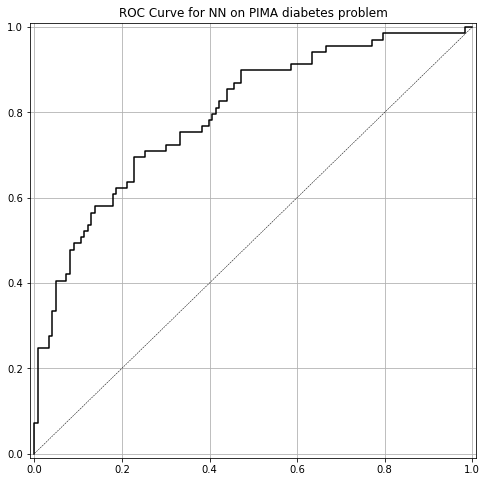

In [46]:
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN')

In [51]:
run_hist_2.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

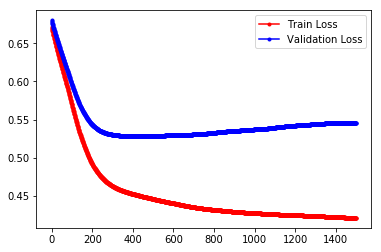

In [48]:
fig, ax = plt.subplots()
ax.plot(run_hist_2.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_2.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

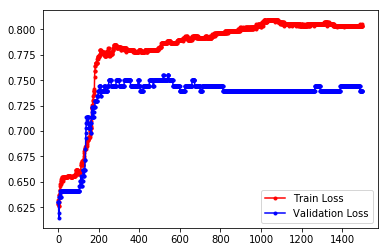

In [52]:
fig, ax = plt.subplots()
ax.plot(run_hist_2.history["acc"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_2.history["val_acc"],'b', marker='.', label="Validation Loss")
ax.legend()

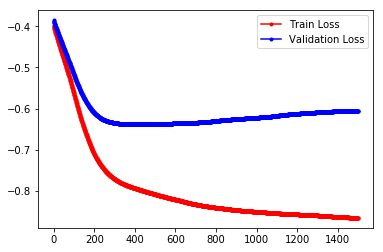

In [53]:
fig, ax = plt.subplots()
ax.plot(np.log(run_hist_2.history["loss"]),'r', marker='.', label="Train Loss")
ax.plot(np.log(run_hist_2.history["val_loss"]),'b', marker='.', label="Validation Loss")
ax.legend()